**Table of contents**

* [Data](#data)
* [Hidden Markov Models](#hmm)
    * [Marginal probability](#marginal)
* [Extensions](#extensions)
* [Implementation](#code)
* [Experiments](#exp)


**General notes**

* In this notebook you are expected to use $\LaTeX$. 
* Use python3.
* Use NLTK to read annotated data.
* **Document your code**: TAs are more likely to understand the steps if you document them. If you don't, it's also difficult to give you partial points for exercises that are not completely correct.

After completing this lab you should be able to 


# <a name="data"> Data

It's good practice to know your data well, so this is what we do in this section. We will be using `nltk` to load data manually annotated with POS tags.

In [1]:
# Read annotated corpora with NLTK
# first download data
import nltk
#nltk.download()
# it will open a GUI and you have to double click in "all" to download 
# this will download different types of annotated corpora

With NLTK, we load the annotated **Penn Treebank** corpus.
This corpus will be used to train and test our PoS taggers. 

In [2]:
# inspect PoS from Treebank
# we use the universal tagset
treebank_sents = nltk.corpus.treebank.tagged_sents(tagset='universal')
print(len(treebank_sents))

3914


Let's use the:
* first 3000 sentences for training, 
* the next 100 sentences for validation, 
* and the remaining 814 sentences for test.

In [3]:
# we split our corpus on training, dev and test
treebank_training = list(treebank_sents[:3000]) 
treebank_dev = list(treebank_sents[3000:3100])
treebank_test = list(treebank_sents[3100:])

print('Training instances:', len(treebank_training)) # if it takes too long/memory only use 1000 instances for training!
print('Development/validation instances:', len(treebank_dev)) # we use 100 sentences/instances for validation
print('Test instances:', len(treebank_test)) # we use 814 sentences/instances for test

Training instances: 3000
Development/validation instances: 100
Test instances: 814


Two sets are particularly important to us:
* the vocabulary of the language,
* and the POS tagset.

In [4]:
# which is the vocabulary?
# we can inspect the vocabulary of the corpus 
vocabulary = set([w for (w, t) in nltk.corpus.treebank.tagged_words(tagset='universal')])
# number of words in our corpus
print('Unique words:', len(vocabulary)) 

Unique words: 12408


In [5]:
# we inspect the universal tagset (this is a general mapping becasue each languge use a different tagset.
tagset = set([t for (w, t) in nltk.corpus.treebank.tagged_words(tagset='universal')])
print('Unique tags:', len(tagset))

Unique tags: 12


The tagset is small enough that we can inspect it:

In [16]:
print(tagset) # tags/labes used to annotate the word class

{'ADV', 'DET', 'CONJ', 'VERB', 'NOUN', 'ADJ', 'ADP', 'X', 'PRT', 'PRON', '.', 'NUM'}


We will use to helper classes to organise our dataset:
* `CorpusSplit` will keep a slice of the PTB, for example, the training, validation, or test portion;
* `Corpus` will keep the three important parts in an experiment (training, validation, and test), each a `CorpusSplit` object.

In [17]:
class CorpusSplit:
    """
    This class helps us manage annotated sequences that are part of 
    """
        
    def __init__(self, corpus):
        sentences = []
        tag_sequences = []
        for observations in corpus:
            sentences.append([x for x, c in observations])
            tag_sequences.append([c for x, c in observations])
        self._sentences = sentences
        self._tag_sequences = tag_sequences
        
    def __len__(self):
        """Size of the split"""
        return len(self._sentences)
    
    def iter_sentences(self):
        return iter(self._sentences)
    
    def iter_tag_sequences(self):
        return iter(self._tag_sequences)
    
    def iter_observations(self):
        return zip(self._sentences, self._tag_sequences)
    
    def observation(self, i):
        """Retrieves the ith observation"""
        if not (0 <= i < len(self)):
            raise ValueError('Out of bounds: %d/%d' % (i, len(self)))
        return self._sentences[i], self._tag_sequences[i]
    
    def sentence(self, i):     
        """Retrieves the ith sentence"""
        if not (0 <= i < len(self)):
            raise ValueError('Out of bounds: %d/%d' % (i, len(self)))
        return self._sentences[i]
    
    def tag_sequence(self, i):
        """Retrieves the ith tag-sequence"""
        if not (0 <= i < len(self)):
            raise ValueError('Out of bounds: %d/%d' % (i, len(self)))
        return self._tag_sequences[i]    

In [18]:
class Corpus:
    
    def __init__(self, training: CorpusSplit, validation: CorpusSplit, test: CorpusSplit):
        self.training = training
        self.validation = validation
        self.test = test
        
    def __str__(self):
        return 'Training (%d) /  Validation (%d) / Test (%d)' % (len(self.training), len(self.validation), len(self.test))

In [19]:
ptb = Corpus(
    training=CorpusSplit(treebank_training),
    validation=CorpusSplit(treebank_dev),
    test=CorpusSplit(treebank_test))
print(ptb)

Training (3000) /  Validation (100) / Test (814)


Let's inspect a few training instances

In [20]:
def observation_to_string(sentence, tag_sequence, horizontal=True):
    """Makes a nice string out of the ith observation"""
    if horizontal:
        return ' '.join('%s/%s' % (x, c) for x, c in zip(sentence, tag_sequence))
    else:
        return ''.join('%s\t%s\n' % (x, c) for x, c in zip(sentence, tag_sequence))

In [25]:
# And a few more
for s in [0, 5, 10]:
    print('Observation #%d' % s)
    print(observation_to_string(ptb.training.sentence(0), ptb.training.tag_sequence(0)))
    print()

Observation #0
Pierre/NOUN Vinken/NOUN ,/. 61/NUM years/NOUN old/ADJ ,/. will/VERB join/VERB the/DET board/NOUN as/ADP a/DET nonexecutive/ADJ director/NOUN Nov./NOUN 29/NUM ./.

Observation #5
Pierre/NOUN Vinken/NOUN ,/. 61/NUM years/NOUN old/ADJ ,/. will/VERB join/VERB the/DET board/NOUN as/ADP a/DET nonexecutive/ADJ director/NOUN Nov./NOUN 29/NUM ./.

Observation #10
Pierre/NOUN Vinken/NOUN ,/. 61/NUM years/NOUN old/ADJ ,/. will/VERB join/VERB the/DET board/NOUN as/ADP a/DET nonexecutive/ADJ director/NOUN Nov./NOUN 29/NUM ./.



In [26]:
# We can also print differently
print(observation_to_string(*ptb.training.observation(0), horizontal=False))

Pierre	NOUN
Vinken	NOUN
,	.
61	NUM
years	NOUN
old	ADJ
,	.
will	VERB
join	VERB
the	DET
board	NOUN
as	ADP
a	DET
nonexecutive	ADJ
director	NOUN
Nov.	NOUN
29	NUM
.	.



# <a name="hmm"> Hidden Markov Models


The Hidden Markov Model **HMM** models the joint probability of a sequence of words and their corresponding tags via a first-order Markov model over the tags where words are conditionally independent given their corresponding tags.


We consider two generative processes:
* Transition: we move from one "state" to another "state" where our state is the POS tag
* Emission: with a certain "state" in mind, we generate a certain word

Let's inspect an example of observation:

In [27]:
print(observation_to_string(*ptb.training.observation(0)))

Pierre/NOUN Vinken/NOUN ,/. 61/NUM years/NOUN old/ADJ ,/. will/VERB join/VERB the/DET board/NOUN as/ADP a/DET nonexecutive/ADJ director/NOUN Nov./NOUN 29/NUM ./.


This means that in the sentence above, for example, we generate
1. From the state `BoS` (begin of sequence) we generate the state `NOUN`
2. Then from `NOUN` we generate the word `Mr.`
3. We then "forget" the word we just emitted and use the fact that our current state is `NOUN` to generate the next state, which is again a `NOUN`
4. From where we then generate `Vinken`
5. We proceed like that until we exaust both sequences


Let us give names to things, let's model the current class with a random variable $C$ and let's use the random variable $C_{\text{prev}}$ to model the previous category. For the word we will use the random variable $X$.
Both $C$ and $C_{\text{prev}}$ take on values in the enumeration of a tagset containing $t$ tags, that is, $\{1, \ldots, t\}$. $X$ takes on values in the enumeration of a vocabulary containing $v$ words, that is, $\{1, \ldots, v\}$.


The **transition** distribution captures how our beliefs in a class vary as a function of the previous class. We will use Categorical distributions for that. In fact, for each possible previous class we get a Categorical distribution over the complete set of classes.

\begin{align}
(1) \qquad C \mid C_{\text{prev}}=p \sim \text{Cat}(\lambda_1^{(p)}, \ldots, \lambda_t^{(p)})
\end{align}
    


The **emission** distribution captures how our beliefs in a word vary as a function of the word's class. We will again use Categorical distributions for that. In fact, for each possible class, we get a Categorical distribution over the complete vocabulary.


\begin{align}
(2) \qquad X \mid C=c \sim \text{Cat}(\theta_1^{(c)}, \ldots, \theta_v^{(c)})
\end{align}
   

The HMM assigns a joint distribution over a sentence $x_1^n$ and its tag sequence $c_1^n$.

To get to this joint distribution, let's first express $P_{CX|C_{\text{prev}}}$, a joint distribution over classes and 
words, where we focus on a single step. Then the model factorises as follows:

\begin{align}
(3) \qquad P_{XC|C_{\text{prev}}}(x, c | c_{\text{prev}}) &= P_{C|C_{\text{prev}}}(c|c_{\text{prev}}) P_{X|C}(x|c) 
\end{align}




We can then simply iterate over the steps in a sequence pair generating both observations:

\begin{align}
(4) \qquad P_{X_1^nC_1^n|N}(x_1^n, c_1^n|n) &= P_{XC|C_{\text{prev}}}(x_1, c_1|c_0)P_{XC|C_{\text{prev}}}(x_2, c_2|c_1)\cdots P_{XC|C_{\text{prev}}}(x_n, c_n|c_{n-1})\\
&=P_{C|C_{\text{prev}}}(c_1|c_0)P_{X|C}(x_1|c_1)P_{C|C_{\text{prev}}}(c_2|c_1)P_{X|C}(x_2|c_1)\cdots P_{C|C_{\text{prev}}}(c_n|c_{n-1})P_{X|C}(x_n|c_n) \\
    &= \prod_{i=1}^n P_{C|C_{\text{prev}}}(c_i|c_{i-1})P_{X|C}(x_i|c_i)
\end{align}




## <a name="marginal"> Marginal probability

---

**Errata** There was an error in how we exposed the marginal probability previously. It will be corrected in class, and here you will find a step by step view of the correct solution

---

In case we use an HMM as a language model, our ultimate goal is to assing a probability to a sentence $x_1^n$, regardless of its tag sequence. 
For that we need to marginalise away all possible assignments to $C_1^n$, where every $C_i$ may take on any of the $t$ available tags.

\begin{align}
(5) \qquad P_{S|N}(x_1^n|n) &= \sum_{c_1=1}^t \cdots \sum_{c_n=1}^t P_{X_1^nC_1^n|N}(x_1^n, c_1^n|n) \\
&= \sum_{c_1=1}^t \cdots \sum_{c_n=1}^t  \underbrace{\prod_{i=1}^n P(c_i|c_{i-1})P(x_i|c_i)}_{\text{From Eq (4)}}\\
&=\sum_{c_1=1}^t \cdots \sum_{c_n=1}^t P(c_1|c_0)P(x_1|c_1)P(c_2|c_1)P(x_2|c_1)\cdots P(c_n|c_{n-1})P(x_n|c_n) 
\end{align}

This looks pretty bad! If we have to enumerate all possible tag sequences, there would be just too many of them. That is, in the first sum, $c_1$ takes 1 of $t$ values, then for each of those values $c_2$ will take 1 of $t$ values, and so on. This leads to $t^n$ different tag sequences. An exponential number of them!!! We will never manage to enumerate them, compute their joint probabilities and then sum them up. 


Let's see if we can simplify this task!

Let's start easy with a short sequence where $n=3$ and let's consider marginalising the first tag out. First recall the joint distribution:

\begin{align}
(6) \qquad P(\langle x_1, x_2, x_3 \rangle, \langle c_1, c_2, c_3 \rangle) &= P_{C|C_{\text{prev}}}(c_1|c_0=\text{BoS}) P_{X|C}(x_1|c_1)\\
&\times P_{C|C_{\text{prev}}}(c_2|c_1) P_{X|C}(x_2|c_2)\\
&\times P_{C|C_{\text{prev}}}(c_3|c_2) P_{X|C}(x_3|c_3)\\
&\times P_{C|C_{\text{prev}}}(\text{EoS}|c_3)P_{X|C}(\text{</s>}|\text{EoS})
\end{align}

Recall that transition to `-EOS-` tag and emission of `</s>` token are factored in for convenience. To avoid clutter we hide the conditioning on length.

Recall that $C_0$ is always deterministically set to `-BOS-`, thus there's no uncertainty as to which tag precedes $c_1$.

Let's call $\alpha_1(c)$ the total probability that we generate $X=x_1, C_1=c$, namely, 

\begin{equation}
(7) \qquad \alpha_1(c_1) = P_{X|C}(x_1|c_1)P_{C|C_{\text{prev}}}(c_1|c_0=\text{BoS})
\end{equation}

Now let's marginalise assignments to $C_1$:

\begin{align}
(8) \qquad &P(\langle x_1, x_2, x_3 \rangle, \langle \cdot, c_2, c_3 \rangle) = \sum_{c_1=1}^t P(\langle x_1, x_2, x_3 \rangle,\langle c_1, c_2, c_3 \rangle) \\
    &= \sum_{c_1=1}^t \underbrace{\underbrace{P(c_1|c_0)P(x_1|c_1)}_{\alpha_1}P(c_2|c_1)P(x_2|c_2)P(c_3|c_2)P(x_3|c_3) P_{XC|C_{\text{prev}}}(\text{</s>},\text{EoS}|c_3)}_{\text{From Eq (3)}} \\
    &= \sum_{c_1=1}^t \alpha_1(c_1) \times P(c_2|c_1)P(x_2|c_2)P(c_3|c_2)P(x_3|c_3)P_{XC|C_{\text{prev}}}(\text{</s>},\text{EoS}|c_3) \\
    &= \underbrace{P(x_2|c_2) \times \left( \sum_{c_1=1}^t \alpha_1(c_1) \times P(c_2|c_1) \right)}_{\alpha_2(c_2)} \times P(c_3|c_2)P(x_3|c_3)P_{XC|C_{\text{prev}}}(\text{</s>},\text{EoS}|c_3) \\
\end{align}

Note that:
* we reuse the result in (7)
* we factorised $P(x_2|c_2)$ out of the sum, as it does not depend on $c_1$;
* we also factorised $P(c_3|c_2)P(x_3|c_3)P_{XC|C_{\text{prev}}}(\text{</s>},\text{EoS}|c_3)$ out of the sum, as it also does not depend on $c_1$
* we identified $\alpha_2(c_2)$: which refers to the marginal probability where we have marginalised $C_1$, we have just generated $X_2=x_2, C_2=c_2$, and we are yet to generate $(\langle x_3, \text{</s>}\rangle, \langle c_3, \text{EoS}\rangle)$

Now let's marginalise assignments to $C_2$:

\begin{align}
(9) \qquad &P(\langle \cdot, \cdot, c_3 \rangle, \langle x_1, x_2, x_3 \rangle) = \sum_{c_2=1}^t P(\langle \cdot, c_2, c_3 \rangle, \langle x_1, x_2, x_3 \rangle) \\
    &= \sum_{c_2=1}^t \underbrace{\alpha_2(c_2) \times P(c_3|c_2)P(x_3|c_3)P_{XC|C_{\text{prev}}}(\text{</s>},\text{EoS}|c_3)}_{\text{From Eq (8)}}\\
    &= \underbrace{P(x_3|c_3) \times \left (\sum_{c_2=1}^t \alpha_2(c_2) \times P(c_3|c_2) \right)}_{\alpha_3(c_3)} P_{XC|C_{\text{prev}}}(\text{</s>},\text{EoS}|c_3) \\
\end{align}


* where we reuse the previous results
* again we factor a term out, namely $P(x_3|c_3)$, as it does not depend on $c_2$
* this time we factore $P_{XC|C_{\text{prev}}}(\text{</s>},\text{EoS}|c_3)$ out because it does not depend on $c_2$ either
* we identify $\alpha_3(c_3)$: which refers to the marginal probability where we have marginalised joint assignments to $C_1$ and $C_2$, we have just generated $X_3=x_3, C_3=c_3$ and are yet to generate $(\text{</s>}, \text{EoS})$.




Now let's finally marginalise assignments to $C_3$

\begin{align}
(10) \qquad &P(\langle \cdot, \cdot, \cdot \rangle, \langle x_1, x_2, x_3 \rangle) = \sum_{c_3=1}^t P(\langle \cdot, \cdot, c_3 \rangle, \langle x_1, x_2, x_3 \rangle) \\
&= \sum_{c_3=1}^t \underbrace{\alpha_3(c_3) \times P_{XC|C_{\text{prev}}}(\text{</s>},\text{EoS}|c_3)}_{\text{From Eq (9)}} \\
&= \underbrace{P_{X|C_{\text{prev}}}(\text{</s>}|\text{EoS}) \times \left( \sum_{c_3=1}^t \alpha_3(c_3) \times P_{C|C_{\text{prev}}}(\text{EoS}|c_3) \right)}_{\alpha_{4}(\text{EoS})}\\
&= P_{X_1^n|N}(x_1^3|n)
\end{align}

which yields the marginal of interest, namely, the probability of the sequence of words regardless of tags!


The quantity $\alpha_i(c)$ we identified along the way is called the **forward probability**, for an observation $x_{\le i}$ (note that we incude the $i$th word here), it corresponds to the probability of marginalising out the sequence $C_{<i}$ ($i$th tag not included), and generating the pair $X_i=x_i, C_i=c$.

\begin{align}
(11) \qquad \alpha_i = P_{X|C}(x_i|c_i) \sum_{c_{i-1}=1}^t \alpha_{i-1} \times P_{C|C_{\text{prev}}}(c_i|c_{i-1})
\end{align}

This recursively formula can be efficient implemented to yield marginal probabilities (an iterative implementation is also possible).

The marginal probability of a sentence $x_1^n$ is therefore
\begin{equation}
(12) \qquad P_{S|N}(x_1^n|n) = \alpha_{n+1}(\text{EoS})
\end{equation}
that is, the probability of $x_1^n$ where:
* we marginalise joint assignments to $C_1^n$ 
* and generate the end of sequence symbols: $X_{n+1}=\text{</s>}, C_{n+1}=\text{EoS}$.

# <a name="extensions"> Extensions

We can extend the HMM to further lexicalise its distributions, for example, we can make transition probabilities  depend on the previously emited word in addition to the previous class. This extension would look like the following:



\begin{align}
(13) \qquad C \mid C_{\text{prev}}=p, X_{\text{prev}}=w \sim \text{Cat}(\lambda_1^{(p,w)}, \ldots, \lambda_t^{(p,w)})
\end{align}

which certainly leads to far more parameters being necessary. It's worth thinking about the following:

* How many parameters do we need to estimate?
* What's the graphical model that depicts the new set of conditional independence assumptions?
* What's the joint probability of observations?
* How does the extension affect marginal probabilities?

Another extension is to combine an HMM and a bigram LM, in this case our emission distributions condition on the previously emited word in addition to the current class. This extension would look like the following:


\begin{align}
(14) \qquad X \mid C=c, X_{\text{prev}}=w \sim \text{Cat}(\theta_1^{(c,w)}, \ldots, \theta_v^{(c,w)})
\end{align}
   
Again, it's worth thinking about the following:

* How many parameters do we need to estimate?
* What's the graphical model that depicts the new set of conditional independence assumptions?
* What's the joint probability of observations?
* How does the extension affect marginal probabilities?

These two modifications are likely to demand too many parameters, so a *modelling assumption* might be to make the following simplifications:

\begin{equation}
(15) \qquad P_{C|C_{\text{prev}}X_{\text{prev}}}(c|p,w) = \beta_0 P_{C|C_{\text{prev}}}(c|p) + (1 - \beta_0) P_{C|X_{\text{prev}}}(c|w)
\end{equation}

\begin{equation}
(16) \qquad P_{X|CX_{\text{prev}}}(x|c,w) = \beta_1 P_{X|C}(x|c) + (1 - \beta_1) P_{X|X_{\text{prev}}}(x|w)
\end{equation}

for interpolation coefficients $0 \le \beta_0 < 1$ and $0 \le \beta_1 < 1 $, where we interpolate the original HMM's cpds with two other cpds obtained by conditioning on the previously emited word.

This leads to difficulty in finding maximum likelihood estimates, but for a *fixed* choice of $\beta_0$ and $\beta_1$, MLE is as simple as performing MLE for each cpd independently. 

This can be done in addition to typical Laplace smoothing.

Finding a good configuration of hyperparameters (e.g. interpolation coefficients, smoothing constants) now requires grid search using improved performance on held out data as a selection criterion.

# <a name="code"> Implementation

In [28]:
import numpy as np
from collections import defaultdict

class HMMLM:
    """
    This is our HMM language model class.
    
    It will be responsible for estimating parameters by MLE
    as well as computing probabilities using the HMM.
    
    We will use Laplace smoothing by default (because we do not want to assign 0 probabilities).
    
    GUIDELINES:
        - by convention we will use the string '-UNK-' for an unknown POS tag
            - and '<unk>' for an unknown word
        - don't forget that with Laplace smoothing the unknown symbols have to be in the support of distributions
        - now you will have 2 types of distributions, so you should deal with unknown symbols for both of them
        - we also need padding for sentences and tag sequences, by convention we will use 
            - '-BOS-' and '-EOS-' for padding tag sequences
            - '<s>' and '</s>' for padding sentences
        - do recall that '-BOS-' is **not** a valid tag
            in other words we never *generate* '-BOS-' tags, we only pretend they occur at
            the 0th position of the tag sequence in order to provide conditioning context
            for the first actual tag
        - similarly, '<s>' is not a valid word
            in other words, we never *generate* '<s>' as a word
            in fact '<s>' is optional as no emission event is based on it
        - on the other hand, '-EOS-' is a valid tag
            you should model it as the last event of a tag sequence
        - similarly, '</s>' is a valid word
            you should consider it as the last event of a sentence
            Note: the last emission is always '-EOS-'' to '</s>', if you are suspecting this is unnecessary 
             because this emission will have probability 1.0, you are right about it! We still suggest modelling 
             it anyway, just to simplify your program (for example, if you model this dummy emission anyway, 
             there will be no need for special treatment of the last position).
            
    You can use whatever data structures you like for cpds
        - we suggest python dict or collections.defaultdict
            but you are free to experiment with list and/or np.array if you like
    """
    
    def __init__(self, 
                 # Smoothing C|c_p and C|x_p
                 smoothing_cp_c=1.0, smoothing_xp_c=1.0, 
                 # Smoothing X|c and X|x_p
                 smoothing_c_x=1.0, smoothing_xp_x=1.0, 
                 # Interpolation coefficients (0. for both means we use the standard HMM)
                 interpolate_xp_c=0., interpolate_xp_x=0.):
        self._vocab = set()
        self._tagset = set()
        # CPDs
        self._cp_c_cpds = dict()
        self._xp_c_cpds = dict()
        self._xp_x_cpds = dict()
        self._c_x_cpds = dict()
        # Laplace smoothing coefficients
        self._smoothing_cp_c = smoothing_cp_c
        self._smoothing_xp_c = smoothing_xp_c
        self._smoothing_c_x = smoothing_c_x
        self._smoothing_xp_x = smoothing_xp_x
        # Interpolation coefficients
        self._interpolate_xp_c = interpolate_xp_c
        self._interpolate_xp_x = interpolate_xp_x
        if self._interpolate_xp_c < 0. or self._interpolate_xp_c > 1.0:
            raise ValueError('Interpolation coefficient for C|x_p should be between 0 and 1')
        if self._interpolate_xp_x < 0. or self._interpolate_xp_x > 1.0:
            raise ValueError('Interpolation coefficient for X|x_p should be between 0 and 1')
        
    def tagset(self):
        """
        Return the tagset: a set of all tags seen by the model (including '-UNK-').
        
        You can modify this if you judge necessary (for example, because you decided  to 
            use different datastructures, but do note that we provide you an implementation
            of the Viterbi algorithm that expects this functionality).        
        """        
        # the -BOS- tag is just something for internal representation
        #  in case you have added it to the tagset, we are removing it here
        #  as keeping it would be bad for algorithms such as Viterbi
        # the -UNK- tag must be in the support (due to Laplace smoothing)
        #  thus in case you forgot it, we are adding it now
        return self._tagset - {'-BOS-'} | {'-UNK-'}
    
    def vocab(self):
        """
        Return the vocabulary of words: all words seen by the model (including '<unk>').
        
        You can modify this if you judge necessary (for example, because you decided  to 
            use different datastructures, but do note that we provide you an implementation
            of the Viterbi algorithm that expects this functionality).        
        """        
        # the <s> token is just something for internal representation
        #  in case you have added it to the vocabulary, we are removing it here
        # the <unk> word must be in the support (due to Laplace smoothing)
        #  thus in case you forgot it, we are adding it now
        return self._vocab - {'<s>'} | {'<unk>'}
        
    def preprocess_sentence(self, sentence, bos=True, eos=True):
        """
        Preprocess a sentence by lowercasing its words and possibly padding it.
        
        :param sentence: a list of tokens (each a string)
        :param bos: if True you will get <s> at the beginning 
        :param eos: if True you will get </s> at the end
        :returns: a list of tokens (lowercased strings)
        """
        # lowercase
        sentence = [x.lower() for x in sentence]
        # optional padding
        if bos: 
            sentence = ['<s>'] + sentence
        if eos:
            sentence = sentence + ['</s>']
        return sentence
        
    def preprocess_tag_sequence(self, tag_sequence, bos=True, eos=True):
        """
        Preprocess a tag sequence with optional padding.
        
        :param tag_sequence: a list of tags (each a string)
        :param bos: if True you will get -BOS- at the beginning 
        :param eos: if True you will get -EOS- at the end
        :returns: a list of tokens 
        """
        # optional padding
        if bos:
            tag_sequence = ['-BOS-'] + tag_sequence
        if eos:
            tag_sequence = tag_sequence + ['-EOS-']
        return tag_sequence
    
    @classmethod
    def laplace_smoothing(cls, joint_counts, alpha, sample_space_size):
        cpds = dict()
        for context, counts in joint_counts.items():
            total = 0
            for outcome, n in counts.items():
                total += n
            total += alpha * sample_space_size
            cpd = dict()
            for outcome, n in counts.items():
                cpd[outcome] = (float(n) + alpha) / total
            cpds[context] = cpd
        return cpds
        
    def estimate_model(self, treebank):
        """
        TYPE YOUR SOLUTION
        
        :param treebank: a sequence of observations where
            each observation is a pair of lists ([x_1, ..., x_n], [c_1, ..., c_n])
            and they have not yet been pre-processed 
        
        Estimate the model parameters.
        
        This method does not have to return anything, it simply computes the necessary cpds.        
        """
        # here we manage the counts of joint events
        # I use the shorthand cp for c_prev and xp for x_prev
        cp_c_counts = defaultdict(lambda: defaultdict(int))
        xp_c_counts = defaultdict(lambda: defaultdict(int))
        c_x_counts = defaultdict(lambda: defaultdict(int))
        xp_x_counts = defaultdict(lambda: defaultdict(int))        
        
        # here we manage the known tags and words
        tagset = set()
        # we always add the UNK tag to the tagset in order to implement Laplace smoothing
        tagset.add('-UNK-')
        #tagset.add('-BOS-')
        vocab = set()
        # we always add the UNK word to the vocabulary in order to implement Laplace smoothing
        vocab.add('<unk>')

        # Counting
        for sentence, tag_sequence in treebank:
            # preprocess with special symbols
            sentence = self.preprocess_sentence(sentence)
            tag_sequence = self.preprocess_tag_sequence(tag_sequence)
            # we start from 1 because we know preprocess adds padding
            #  and we don't actually take <s> or -BOS- as observatinos, but just as conditioning
            #  context for the first step
            for i in range(1, len(sentence)):
                x = sentence[i]
                x_prev = sentence[i - 1]
                c = tag_sequence[i]
                c_prev = tag_sequence[i - 1]
 
                cp_c_counts[c_prev][c] += 1
                xp_c_counts[x_prev][c] += 1
                c_x_counts[c][x] += 1
                xp_x_counts[x_prev][x] += 1
                
                # here we add tag to tagset and word to vocabulary
                tagset.add(c)
                vocab.add(x)
                
        #### Laplace smoothing
        # We will make sure -UNK- is in the support of transitions
        #  and <unk> is in the support of emissions
        #  we add a 0 count to transitions/emissions to -UNK-/<unk> to make sure the entries are in the dict
        #  then the function that computes parameters out of counts will take care of Laplace smoothing

        # Where a class is in the conditioning context of another class or word
        for c_prev in tagset | {'-BOS-'}: 
            cp_c_counts[c_prev]['-UNK-'] += 0  # always possible to reach the UNK class            
            c_x_counts[c_prev]['<unk>'] += 0  # always possible to generate the UNK word
                
        # Where a word is in the conditioning context of a class or another word
        for x_prev in vocab | {'<s>'}:
            xp_c_counts[x_prev]['-UNK-'] += 0
            xp_x_counts[x_prev]['<unk>'] += 0

        # MLE
        # Transitions from c_prev to c
        self._cp_c_cpds = self.laplace_smoothing(
            cp_c_counts, alpha=self._smoothing_cp_c, sample_space_size=len(tagset))
        # Transitions from x_prev to c
        self._xp_c_cpds = self.laplace_smoothing(
            xp_c_counts, alpha=self._smoothing_xp_c, sample_space_size=len(tagset))
        # Emissions from c to x
        self._c_x_cpds = self.laplace_smoothing(
            c_x_counts, alpha=self._smoothing_c_x, sample_space_size=len(vocab))
        # Emissions from x_prev to x
        self._xp_x_cpds = self.laplace_smoothing(
            xp_x_counts, alpha=self._smoothing_xp_x, sample_space_size=len(vocab)) 
                                
        # now we store the tagset and vocab
        self._tagset = tagset
        self._vocab = vocab
    
    def transition_parameter(self, c, c_prev, x_prev):
        """
        TYPE YOUR SOLUTION
        
        This method returns the transition probability for tag given the previous tag.
        
        Tips: do not forget that we have a smoothed model, thus 
            - if the either tag was never seen, you should pretend it to be '-UNK-'
        
        :param previous_tag: the previous tag (str)
        :param current_tag: the current tag (str)
        :return: transition parameter
        """
        # if we do not have a cpd for the previous tag, we use the cpd for -UNK-
        cp_c_cpd = self._cp_c_cpds.get(c_prev, self._cp_c_cpds['-UNK-'])
        parameter = cp_c_cpd.get(c, cp_c_cpd['-UNK-'])  
        if self._interpolate_xp_c > 0.:
            xp_c_cpd = self._xp_c_cpds.get(x_prev, self._xp_c_cpds['<unk>'])
            other_parameter = xp_c_cpd.get(c, xp_c_cpd['-UNK-'])
            parameter = parameter * (1 - self._interpolate_xp_c ) + self._interpolate_xp_c * other_parameter
        return parameter
    
    def emission_parameter(self, x, c, x_prev):
        """
        TYPE YOUR SOLUTION
        
        This method returns the emission probability for a word given a tag.
        Tips: do not forget that we have a smoothed model, thus 
            - if the tag was never seen, you should pretend it to be '-UNK-'
            - similarly, if the word was never seen, you shoud pretend it to be '<unk>'
        
        :param tag: the current tag (str)
        :param word: the current word (str)
        :return: the emission probability
        """
        # if we do not have a cpd for this tag, we use the cpd for -UNK-
        c_x_cpd = self._c_x_cpds.get(c, self._c_x_cpds['-UNK-'])
        parameter = c_x_cpd.get(x, c_x_cpd['<unk>'])  
        if self._interpolate_xp_x > 0.:
            xp_x_cpd = self._xp_x_cpds.get(x_prev, self._xp_x_cpds['<unk>'])
            other_parameter = xp_x_cpd.get(x, xp_x_cpd['<unk>'])
            parameter = parameter * (1 - self._interpolate_xp_x ) + self._interpolate_xp_x * other_parameter
        return parameter
    
    def joint_parameter(self, c, x, c_prev, x_prev):
        """
        TYPE YOUR SOLUTION
        
        This method returns the joint probability of (current tag, word) given the previous tag
            according to Equation (3)
            
        :param previous_tag: the previous tag (str)
        :param current_tag: the current tag (str)
        :param word: the current word (str)
        :returns: P(word, current_tag|previous_tag)
        """
        lamb = self.transition_parameter(c=c, c_prev=c_prev, x_prev=x_prev)
        theta = self.emission_parameter(x=x, c=c, x_prev=x_prev)
        return lamb * theta
    
    def log_joint(self, sentence, tag_sequence):
        """
        TYPE YOUR SOLUTION
        
        Implement the logarithm of the joint probability over a sentence and tag sequence as in Equation (8)
        
        :param sentence: a sequence of words (each a string) not yet preprocessed
        :param tag_sequence: a sequence of tags (eac a string) not yet preprocessed
        :returns: log P(x_1^n, c_1^n|n) as defined in Equation (8)
        """ 
        sentence = self.preprocess_sentence(sentence)
        tag_sequence = self.preprocess_tag_sequence(tag_sequence)        
        log_p = 0.
        # we start from 1 because the first step is -BOS-
        for i in range(1, len(sentence)):
            log_p += np.log(self.joint_parameter(
                c=tag_sequence[i], 
                x=sentence[i],
                c_prev=tag_sequence[i - 1], 
                x_prev=sentence[i - 1]))
        return log_p
    
    def log_marginal(self, sentence):
        """We compute forward probabilities and use it to output the marginal log probability of the observation"""
        if not sentence:
            raise ValueError('A sentence cannot be empty')
        sentence = self.preprocess_sentence(sentence)
 
        alpha = [defaultdict(float) for i in range(len(sentence))]
        # Initial state (log prob)
        alpha[0]['-BOS-'] = 0.0
        
        for i, x in enumerate(sentence[1:], 1):
            x_prev = sentence[i - 1]
            to_set = ['-EOS-'] if i == len(sentence) - 1 else self.tagset()
            from_set = ['-BOS-'] if i == 1 else self.tagset()                
            for c in to_set:
                log_prob = - np.inf
                for c_prev in from_set:
                    log_prob = np.logaddexp(log_prob, alpha[i - 1][c_prev] + np.log(self.joint_parameter(c=c, x=x, c_prev=c_prev, x_prev=x_prev)))
                alpha[i][c] = log_prob
        return alpha[len(sentence) - 1]['-EOS-']
    
    def viterbi(self, sentence):
        """This returns the best tag sequence as well as it's log joint probability"""
        if not sentence:
            raise ValueError('A sentence cannot be empty')
        sentence = self.preprocess_sentence(sentence)
 
        alpha = [dict() for i in range(len(sentence))]
        # Initial state (log prob, previous best tag)
        alpha[0]['-BOS-'] = [0.0, '']  # we use an empty previous best tag to C_0 = '-BOS-'
                
        for i, x in enumerate(sentence[1:], 1):
            x_prev = sentence[i - 1]
            to_set = ['-EOS-'] if i == len(sentence) - 1 else self.tagset()
            from_set = ['-BOS-'] if i == 1 else self.tagset()                
            for c in to_set:
                scores = []
                options = []
                for c_prev in from_set:
                    scores.append(alpha[i - 1][c_prev][0] + np.log(self.joint_parameter(c=c, x=x, c_prev=c_prev, x_prev=x_prev)))
                    options.append(c_prev)
                k = np.argmax(scores)         
                alpha[i][c] = [scores[k], options[k]]
        
        viterbi_path = [None] * len(sentence)
        viterbi_score = alpha[i]['-EOS-'][0]
        viterbi_path[-1] = '-EOS-'
        for i in range(1, len(sentence)):
            viterbi_path[-(i + 1)] = alpha[-i][viterbi_path[-i]][1]
        viterbi_tagging = viterbi_path[1:-1]  # discard previous to C_0, C_0='-BOS-', and C_{n+1}='-EOS-'
        return viterbi_tagging, viterbi_score
    
    def log_perplexity(self, sentences):
        """
        For a dataset of sentences (each sentence is a list of words)
            return the log perplexity
        """
        ppl = 0.
        length = 0
        for sentence in sentences:
            ppl += self.log_marginal(sentence)
            length += len(sentence) + 1   # recall the </s> symbol
        return - ppl / length

In [29]:
treebank_hmm = HMMLM(
        # Guideline for smoothing distributions with non-empty conditioning context: 
        #  recall that we divide count(context, outcome) by count(context) + alpha \times |size sample space| 
        #  so let's aim for having alpha equals to 1 count dividided across all of the context space
        #  for example, where we condition on O(v) contexts, alpha = 1 / (v)
        #  where we condition on O(t) contexts, alpha = 1 / (t)
        #  there's no theory here, this is just a rule of thumb to get us started, we should always investigate
        #  a range of values and decide based on performance on dev set
        # Let's say t is in the order of 10 and v is in the order of 10000, then:
        smoothing_c_x=1. / 10,
        smoothing_cp_c=1. / 10,
        smoothing_xp_x= 1. / 10000,
        smoothing_xp_c=1. / 10000,
        # Guideline for interpolation: use 0 if you don't want to interpolate and use less than 1.0 per coefficient
        interpolate_xp_c=0., 
        interpolate_xp_x=0.)

In [30]:
treebank_hmm.estimate_model(ptb.training.iter_observations())

In [43]:
sen=0
viterbi_path, viterbi_score = treebank_hmm.viterbi(ptb.training.sentence(sen))
print(viterbi_path)
print(ptb.training.sentence(sen))
print(len(viterbi_path),len(ptb.training.sentence(sen)))

['NOUN', 'NOUN', '.', 'NUM', 'NOUN', 'NOUN', '.', 'VERB', 'VERB', 'DET', 'NOUN', 'ADP', 'DET', 'ADJ', 'NOUN', 'NOUN', 'NUM', '.']
['Pierre', 'Vinken', ',', '61', 'years', 'old', ',', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'Nov.', '29', '.']
18 18


In [44]:
def compare_pred_gold(sentence, gold, predictions):
    """Makes a nice table comparing gold tags and predicted tags"""    
    return 'Word\tGold\tPred\tScore\n----\t----\t----\t-----\n' + ''.join('%s\t%s\t%s\t%d\n' % (x, g, c, 1 if g == c else 0) for x, g, c in zip(sentence, gold, predictions))

In [45]:
print(compare_pred_gold(ptb.training.sentence(0), ptb.training.tag_sequence(0), viterbi_path))

Word	Gold	Pred	Score
----	----	----	-----
Pierre	NOUN	NOUN	1
Vinken	NOUN	NOUN	1
,	.	.	1
61	NUM	NUM	1
years	NOUN	NOUN	1
old	ADJ	NOUN	0
,	.	.	1
will	VERB	VERB	1
join	VERB	VERB	1
the	DET	DET	1
board	NOUN	NOUN	1
as	ADP	ADP	1
a	DET	DET	1
nonexecutive	ADJ	ADJ	1
director	NOUN	NOUN	1
Nov.	NOUN	NOUN	1
29	NUM	NUM	1
.	.	.	1



In [46]:
def accuracy(gold_sequences, pred_sequences):
    """
    Return percentage of instances in the test data that our tagger labeled correctly.
    
    :param gold_sequences: a list of tag sequences that can be assumed to be correct
    :param pred_sequences: a list of tag sequences predicted by Viterbi    
    """
    correct = 0
    total = 0
    for gold, pred in zip(gold_sequences, pred_sequences):
        correct += np.sum([x == y for x, y in zip(gold, pred)])
        total += len(gold)
    return float(correct) / total

In [47]:
# we use our trained model to do some predictions of the test sets
def tag_sentences(sentences, model: HMMLM):
    pred = []
    for sentence in sentences:
        # viterbi recursion gives us the predicted tags for each sentence
        viterbi_path, _ = model.viterbi(sentence)
        pred.append(viterbi_path)
    return pred

# <a name="exp"> Experiments

Here we illustrate an experiment where we vary the interpolation level of either type of distribution holding the other at 0. It's expected that interpolating for emissions may help perplexity, interpolating for transitions may help accuracy. The interaction of the two extensions is also interesting. Additionally, there's an interaction with Laplace smoothing. All in all, various hyperparameters to try out.

In [50]:
for interpolate_xp_x in [0.,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    treebank_hmm = HMMLM(
        # Guideline for smoothing distributions with non-empty conditioning context: 
        #  recall that we divide count(context, outcome) by count(context) + alpha \times |size sample space| 
        #  so let's aim for having alpha equals to 1 count dividided across all of the context space
        #  for example, where we condition on O(v) contexts, alpha = 1 / (v)
        #  where we condition on O(t) contexts, alpha = 1 / (t)
        #  there's no theory here, this is just a rule of thumb to get us started, we should always investigate
        #  a range of values and decide based on performance on dev set
        # Let's say t is in the order of 10 and v is in the order of 10000, then:
        smoothing_c_x=1. / 10,
        smoothing_cp_c=1. / 10,
        smoothing_xp_x= 1. / 10000,
        smoothing_xp_c=1. / 10000,
        # Guideline for interpolation: use 0 if you don't want to interpolate and use less than 1.0 per coefficient
        interpolate_xp_c=0., 
        interpolate_xp_x=interpolate_xp_x)
    print('Interpolation level for X|x_prev and X|c:', interpolate_xp_x)
    treebank_hmm.estimate_model(ptb.training.iter_observations())
    
    print('Joint parameter for the/DET book/NOUN:', treebank_hmm.joint_parameter(c_prev='DET', x_prev='the', c='NOUN', x='book'))
    
    print(observation_to_string(*ptb.validation.observation(0)))
    print('log P(x,c):', treebank_hmm.log_joint(*ptb.validation.observation(0)))
    print('log P(x):', treebank_hmm.log_marginal(ptb.validation.sentence(0)))
    
    print('Debugging marginal algorithm')
    # This is how you can debug the marginal probability, but be careful, this exhaustively enumerates
    #  all tag sequences, that's why we make a 2-word long sequence
    log_prob = float('-inf')
    for p in treebank_hmm.tagset():
        for c in treebank_hmm.tagset():
            log_prob = np.logaddexp(log_prob, treebank_hmm.log_joint(['i', 'wish'], [p, c]))
    print('Exhaustive log P(<i wish>):', log_prob)
    print('Dynamic program log P(<i wish>):', treebank_hmm.log_marginal(['i', 'wish']))

    print('Dev set perplexity:', treebank_hmm.log_perplexity(ptb.validation.iter_sentences()))    
    
    # extract sentences from test corpus
    pred_treebank = tag_sentences(ptb.validation.iter_sentences(), treebank_hmm)
    # we compute the evaluations metrics for PTB
    acc = accuracy(ptb.validation.iter_tag_sequences(), pred_treebank)
    print('Dev set tagging accuracy:', acc)
    
    print()

Interpolation level for X|x_prev and X|c: 0.0
Joint parameter for the/DET book/NOUN: 0.00011353114209461058
At/ADP Tokyo/NOUN ,/. the/DET Nikkei/NOUN index/NOUN of/ADP 225/NUM selected/VERB issues/NOUN ,/. which/DET *T*-1/X gained/VERB 132/NUM points/NOUN Tuesday/NOUN ,/. added/VERB 14.99/NUM points/NOUN to/PRT 35564.43/NUM ./.
log P(x,c): -188.1486405081697
log P(x): -172.91881754034597
Debugging marginal algorithm
Exhaustive log P(<i wish>): -21.939373536546874
Dynamic program log P(<i wish>): -21.93937353654687
Dev set perplexity: 6.615841701501539
Dev set tagging accuracy: 0.8937937062937062

Interpolation level for X|x_prev and X|c: 0.1
Joint parameter for the/DET book/NOUN: 0.00010217975224047863
At/ADP Tokyo/NOUN ,/. the/DET Nikkei/NOUN index/NOUN of/ADP 225/NUM selected/VERB issues/NOUN ,/. which/DET *T*-1/X gained/VERB 132/NUM points/NOUN Tuesday/NOUN ,/. added/VERB 14.99/NUM points/NOUN to/PRT 35564.43/NUM ./.
log P(x,c): -187.45464181736594
log P(x): -168.4577464957235
Debug

In [57]:
accuracy_matrix = np.zeros((11,11))

for interpolate_xp_x in [0.,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    for interpolate_xp_c in [0.,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
        treebank_hmm = HMMLM(
            # Guideline for smoothing distributions with non-empty conditioning context: 
            #  recall that we divide count(context, outcome) by count(context) + alpha \times |size sample space| 
            #  so let's aim for having alpha equals to 1 count dividided across all of the context space
            #  for example, where we condition on O(v) contexts, alpha = 1 / (v)
            #  where we condition on O(t) contexts, alpha = 1 / (t)
            #  there's no theory here, this is just a rule of thumb to get us started, we should always investigate
            #  a range of values and decide based on performance on dev set
            # Let's say t is in the order of 10 and v is in the order of 10000, then:
            smoothing_c_x=1. / 10,
            smoothing_cp_c=1. / 10,
            smoothing_xp_x= 1. / 10000,
            smoothing_xp_c=1. / 10000,
            # Guideline for interpolation: use 0 if you don't want to interpolate and use less than 1.0 per coefficient
            interpolate_xp_c=interpolate_xp_c, 
            interpolate_xp_x=interpolate_xp_x)
        print('Interpolation level for C|x_prev and C|c:', interpolate_xp_c)
        print('Interpolation level for X|x_prev and X|c:', interpolate_xp_x)
        treebank_hmm.estimate_model(ptb.training.iter_observations())

#         print('Joint parameter for the/DET book/NOUN:', treebank_hmm.joint_parameter(c_prev='DET', x_prev='the', c='NOUN', x='book'))

#         print(observation_to_string(*ptb.validation.observation(0)))
#         print('log P(x,c):', treebank_hmm.log_joint(*ptb.validation.observation(0)))
#         print('log P(x):', treebank_hmm.log_marginal(ptb.validation.sentence(0)))

#         print('Debugging marginal algorithm')
        # This is how you can debug the marginal probability, but be careful, this exhaustively enumerates
        #  all tag sequences, that's why we make a 2-word long sequence
        log_prob = float('-inf')
        for p in treebank_hmm.tagset():
            for c in treebank_hmm.tagset():
                log_prob = np.logaddexp(log_prob, treebank_hmm.log_joint(['i', 'wish'], [p, c]))
#         print('Exhaustive log P(<i wish>):', log_prob)
#         print('Dynamic program log P(<i wish>):', treebank_hmm.log_marginal(['i', 'wish']))

#         print('Dev set perplexity:', treebank_hmm.log_perplexity(ptb.validation.iter_sentences()))    

        # extract sentences from test corpus
        pred_treebank = tag_sentences(ptb.validation.iter_sentences(), treebank_hmm)
        # we compute the evaluations metrics for PTB
        acc = accuracy(ptb.validation.iter_tag_sequences(), pred_treebank)
        accuracy_matrix[int(interpolate_xp_c*10)][int(interpolate_xp_x*10)] = acc
        print('Dev set tagging accuracy:', acc)

        print()
print(accuracy_matrix)

Interpolation level for C|x_prev and C|c: 0.0
Interpolation level for X|x_prev and X|c: 0.0
Dev set tagging accuracy: 0.8937937062937062

Interpolation level for C|x_prev and C|c: 0.1
Interpolation level for X|x_prev and X|c: 0.0
Dev set tagging accuracy: 0.8981643356643356

Interpolation level for C|x_prev and C|c: 0.2
Interpolation level for X|x_prev and X|c: 0.0
Dev set tagging accuracy: 0.8986013986013986

Interpolation level for C|x_prev and C|c: 0.3
Interpolation level for X|x_prev and X|c: 0.0
Dev set tagging accuracy: 0.8986013986013986

Interpolation level for C|x_prev and C|c: 0.4
Interpolation level for X|x_prev and X|c: 0.0
Dev set tagging accuracy: 0.8994755244755245

Interpolation level for C|x_prev and C|c: 0.5
Interpolation level for X|x_prev and X|c: 0.0
Dev set tagging accuracy: 0.8986013986013986

Interpolation level for C|x_prev and C|c: 0.6
Interpolation level for X|x_prev and X|c: 0.0
Dev set tagging accuracy: 0.895541958041958

Interpolation level for C|x_prev an

Dev set tagging accuracy: 0.8208041958041958

Interpolation level for C|x_prev and C|c: 0.5
Interpolation level for X|x_prev and X|c: 0.5
Dev set tagging accuracy: 0.8273601398601399

Interpolation level for C|x_prev and C|c: 0.6
Interpolation level for X|x_prev and X|c: 0.5
Dev set tagging accuracy: 0.826486013986014

Interpolation level for C|x_prev and C|c: 0.7
Interpolation level for X|x_prev and X|c: 0.5
Dev set tagging accuracy: 0.8243006993006993

Interpolation level for C|x_prev and C|c: 0.8
Interpolation level for X|x_prev and X|c: 0.5
Dev set tagging accuracy: 0.8085664335664335

Interpolation level for C|x_prev and C|c: 0.9
Interpolation level for X|x_prev and X|c: 0.5
Dev set tagging accuracy: 0.7937062937062938

Interpolation level for C|x_prev and C|c: 1
Interpolation level for X|x_prev and X|c: 0.5
Dev set tagging accuracy: 0.7338286713286714

Interpolation level for C|x_prev and C|c: 0.0
Interpolation level for X|x_prev and X|c: 0.6
Dev set tagging accuracy: 0.698426573

Dev set tagging accuracy: 0.4007867132867133

[[0.89379371 0.84003497 0.80113636 0.78146853 0.75786713 0.74038462
  0.69842657 0.67263986 0.6451049  0.60052448 0.23645105]
 [0.89816434 0.86363636 0.83872378 0.80332168 0.78452797 0.76442308
  0.73513986 0.6993007  0.67788462 0.63548951 0.32561189]
 [0.8986014  0.87587413 0.8631993  0.83085664 0.80681818 0.78190559
  0.76136364 0.73339161 0.70804196 0.66127622 0.36232517]
 [0.8986014  0.8833042  0.86756993 0.84965035 0.82561189 0.80681818
  0.78802448 0.75524476 0.72814685 0.68312937 0.39685315]
 [0.89947552 0.8833042  0.87237762 0.8548951  0.83784965 0.8208042
  0.79632867 0.77622378 0.74737762 0.69493007 0.4291958 ]
 [0.8986014  0.8833042  0.86888112 0.85839161 0.84309441 0.82736014
  0.80638112 0.77928322 0.74781469 0.6993007  0.43356643]
 [0.89554196 0.88024476 0.8666958  0.85576923 0.83916084 0.82648601
  0.80550699 0.78277972 0.74912587 0.70192308 0.44536713]
 [0.89073427 0.87368881 0.86145105 0.85227273 0.83872378 0.8243007
  0.79

[[0.894 0.84  0.801 0.781 0.758 0.74  0.698 0.673 0.645 0.601 0.236]
 [0.898 0.864 0.839 0.803 0.785 0.764 0.735 0.699 0.678 0.635 0.326]
 [0.899 0.876 0.863 0.831 0.807 0.782 0.761 0.733 0.708 0.661 0.362]
 [0.899 0.883 0.868 0.85  0.826 0.807 0.788 0.755 0.728 0.683 0.397]
 [0.899 0.883 0.872 0.855 0.838 0.821 0.796 0.776 0.747 0.695 0.429]
 [0.899 0.883 0.869 0.858 0.843 0.827 0.806 0.779 0.748 0.699 0.434]
 [0.896 0.88  0.867 0.856 0.839 0.826 0.806 0.783 0.749 0.702 0.445]
 [0.891 0.874 0.861 0.852 0.839 0.824 0.799 0.778 0.742 0.698 0.443]
 [0.881 0.862 0.85  0.843 0.827 0.809 0.785 0.762 0.729 0.69  0.435]
 [0.872 0.854 0.843 0.827 0.816 0.794 0.776 0.748 0.709 0.68  0.43 ]
 [0.819 0.8   0.788 0.77  0.755 0.734 0.709 0.689 0.653 0.618 0.401]]
0.8994755244755245


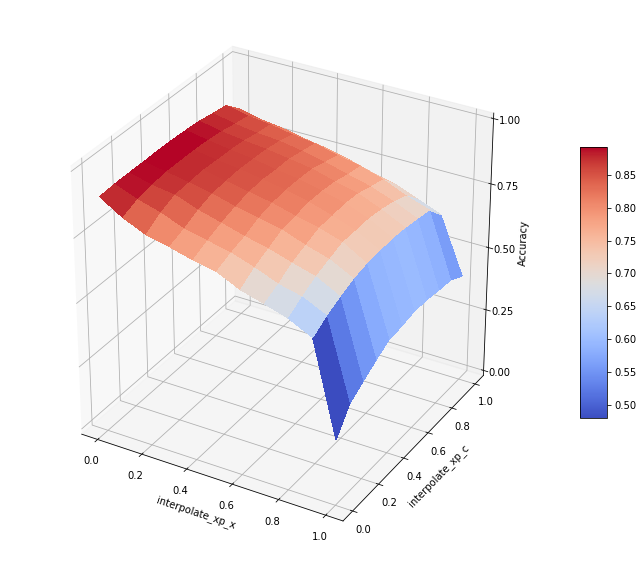

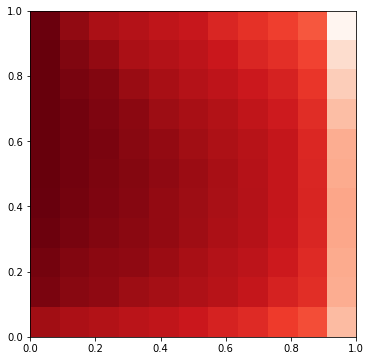

In [155]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

rounded = np.around(accuracy_matrix, decimals=3)
print(rounded)
print(np.max(accuracy_matrix))

# Set up grid and test data
x = [0.,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
y = [0.,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D
# Plot the surface.
surf = ax.plot_surface(X, Y, accuracy_matrix, cmap=cm.coolwarm,
                       linewidth=1, antialiased=False)

# Customize the z axis.
ax.set_zlim(0, 1)
ax.zaxis.set_major_locator(LinearLocator(5))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

# Add labels
ax.set_xlabel('interpolate_xp_x')
ax.set_ylabel('interpolate_xp_c')
ax.set_zlabel('Accuracy')

plt.show()


fig2, ax2 = plt.subplots(figsize=(6,6))

ax2.imshow(accuracy_matrix, cmap=plt.cm.Reds, interpolation='none', extent=[0,1,0,1])